# Capstone Project: Urban Planning of Financial Capitals; A Cluster Analysis

## Introduction

This notebook will conduct K-Means clustering, and agglomerative clustering of neighbourhoods in both Toronto, and Manhattan to measure similarities, and dissimilarities between the two financial centres.

## Importing recquired libraries

In [2]:
# The basics
import re
import numpy as np
import pandas as pd

# For webscraping
import requests
from bs4 import BeautifulSoup as bs

# For getting geo coordinates
import pgeocode

# For plotting and visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

# For K-Means modelling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

## Importing pre-processed dataset

In [3]:
Manhattan_df = pd.read_csv('Manhattan.csv')
Toronto_df = pd.read_csv('Toronto.csv')
Manhattan_geo = pd.read_csv('Manhattan_geo.csv')
Toronto_geo = pd.read_csv('Toronto_geo.csv')

In [4]:
# Build function to transform data
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Looking at Manhattan neighbourhoods

In [5]:
Manhattan_geo.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


### Looking at Manhattan venues

In [6]:
Manhattan_df.head(10)

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.0,0.000000,0.013333,0.00,0.0,0.00000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.013333,0.0,0.013333,0.000000
1,Carnegie Hill,0.0,0.0,0.0,0.000000,0.010870,0.00,0.0,0.01087,0.000000,...,0.0,0.01087,0.0,0.0,0.0,0.01087,0.032609,0.0,0.010870,0.032609
2,Central Harlem,0.0,0.0,0.0,0.065217,0.043478,0.00,0.0,0.00000,0.043478,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
3,Chelsea,0.0,0.0,0.0,0.000000,0.040000,0.00,0.0,0.00000,0.040000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.030000,0.0,0.010000,0.010000
4,Chinatown,0.0,0.0,0.0,0.000000,0.040000,0.00,0.0,0.00000,0.000000,...,0.0,0.02000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.010000
5,Civic Center,0.0,0.0,0.0,0.000000,0.040000,0.01,0.0,0.00000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.01000,0.010000,0.0,0.000000,0.030000
6,Clinton,0.0,0.0,0.0,0.000000,0.040000,0.00,0.0,0.00000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.02000,0.020000,0.0,0.000000,0.000000
7,East Harlem,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
8,East Village,0.0,0.0,0.0,0.000000,0.020000,0.00,0.0,0.01000,0.010000,...,0.0,0.02000,0.0,0.0,0.0,0.03000,0.010000,0.0,0.000000,0.000000
9,Financial District,0.0,0.0,0.0,0.000000,0.040000,0.00,0.0,0.00000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.010000,0.0,0.000000,0.000000


### Looking at Toronto neighbourhoods

In [7]:
Toronto_geo.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.6555,-79.3626
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783
2,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756
3,M4E,East Toronto,The Beaches,43.6784,-79.2941
4,M5E,Downtown Toronto,Berczy Park,43.6456,-79.3754
5,M5G,Downtown Toronto,Central Bay Street,43.6564,-79.3860
6,M6G,Downtown Toronto,Christie,43.6683,-79.4205
7,M5H,Downtown Toronto,"Richmond , Adelaide , King",43.6496,-79.3833
8,M6H,West Toronto,"Dufferin , Dovercourt Village",43.6655,-79.4378
9,M4J,East YorkEast Toronto,The Danforth East,43.6872,-79.3368


### Looking at Toronto venues

In [8]:
Toronto_df.head(10)

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,Berczy Park,0.010753,0.000000,0.000000,0.021505,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.010753,0.000000,0.000000,0.0,0.000000,0.000000
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.025641,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,"CN Tower , King and Spadina , Railway Lands , ...",0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.017241
3,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.016667,0.016667,0.0,0.016667,0.000000
4,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,Church and Wellesley,0.027027,0.000000,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,"Commerce Court , Victoria Hotel",0.000000,0.000000,0.030000,0.010000,0.000000,0.000000,0.030000,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.010000,0.000000,0.000000,0.0,0.010000,0.000000
7,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.0,...,0.0,0.04,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,"Dufferin , Dovercourt Village",0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


## Combining the datasets

In [9]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
Manhattan_venues = pd.DataFrame(columns=columns)
Manhattan_venues['Neighborhood'] = Manhattan_df['Neighborhood']

for ind in np.arange(Manhattan_df.shape[0]):
    Manhattan_venues.iloc[ind, 1:] = return_most_common_venues(Manhattan_df.iloc[ind, :], num_top_venues)

Manhattan_venues.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Gym,Hotel,Memorial Site,Clothing Store,BBQ Joint,Gourmet Shop,Food Court,Pizza Place
1,Carnegie Hill,Coffee Shop,Café,Bar,Yoga Studio,Gym,Bookstore,Cosmetics Shop,French Restaurant,Italian Restaurant,Wine Shop
2,Central Harlem,African Restaurant,Gym / Fitness Center,French Restaurant,Seafood Restaurant,Cosmetics Shop,Art Gallery,Bar,American Restaurant,Chinese Restaurant,Boutique
3,Chelsea,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Art Gallery,Ice Cream Shop,French Restaurant,Seafood Restaurant,Wine Shop,Bar
4,Chinatown,Chinese Restaurant,Bakery,Hotpot Restaurant,Cocktail Bar,Dessert Shop,American Restaurant,Spa,Salon / Barbershop,Shanghai Restaurant,Ice Cream Shop
5,Civic Center,Coffee Shop,Spa,French Restaurant,American Restaurant,Cocktail Bar,Hotel,Gym / Fitness Center,Park,Yoga Studio,Sushi Restaurant
6,Clinton,Italian Restaurant,Gym / Fitness Center,Theater,Cocktail Bar,Coffee Shop,American Restaurant,Sandwich Place,Gym,Spa,Hotel
7,East Harlem,Mexican Restaurant,Deli / Bodega,Bakery,Latin American Restaurant,Thai Restaurant,Sandwich Place,Steakhouse,Spanish Restaurant,Beer Bar,Liquor Store
8,East Village,Bar,Pizza Place,Mexican Restaurant,Korean Restaurant,Ice Cream Shop,Cocktail Bar,Coffee Shop,Vegetarian / Vegan Restaurant,Italian Restaurant,Speakeasy
9,Financial District,Coffee Shop,Italian Restaurant,Bar,Gym,Cocktail Bar,American Restaurant,Gym / Fitness Center,Salad Place,Café,Steakhouse


In [10]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
Toronto_venues = pd.DataFrame(columns=columns)
Toronto_venues['Neighborhood'] = Toronto_df['Neighborhood']

for ind in np.arange(Toronto_df.shape[0]):
    Toronto_venues.iloc[ind, 1:] = return_most_common_venues(Toronto_df.iloc[ind, :], num_top_venues)

Toronto_venues.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Café,Hotel,Seafood Restaurant,Restaurant,Cocktail Bar,Beer Bar,Japanese Restaurant,Pub
1,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Breakfast Spot,Gift Shop,Thrift / Vintage Store,Dance Studio,Brewery,Sandwich Place,Restaurant,Chiropractor
2,"CN Tower , King and Spadina , Railway Lands , ...",Coffee Shop,Italian Restaurant,Café,Bar,Park,Speakeasy,Grocery Store,French Restaurant,Gym / Fitness Center,Bank
3,Central Bay Street,Coffee Shop,Bubble Tea Shop,Clothing Store,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Sandwich Place,Restaurant,Café,Juice Bar
4,Christie,Café,Grocery Store,Park,Coffee Shop,Playground,Candy Store,Athletics & Sports,Baby Store,Fish & Chips Shop,Fast Food Restaurant
5,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Gay Bar,Restaurant,Grocery Store,Hotel,Fast Food Restaurant,Diner,Mediterranean Restaurant
6,"Commerce Court , Victoria Hotel",Coffee Shop,Hotel,Café,Restaurant,Gym,Japanese Restaurant,Seafood Restaurant,American Restaurant,Deli / Bodega,Salad Place
7,Davisville,Sandwich Place,Café,Italian Restaurant,Dessert Shop,Coffee Shop,Gym,Indian Restaurant,Fast Food Restaurant,Flower Shop,Restaurant
8,Davisville North,Food & Drink Shop,Breakfast Spot,Park,Department Store,Dog Run,Electronics Store,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant
9,"Dufferin , Dovercourt Village",Park,Grocery Store,Bakery,Brazilian Restaurant,Art Gallery,Gym,Bus Line,Pharmacy,Smoke Shop,Middle Eastern Restaurant


## Finding the optimal number of clusters

In [11]:
Manhattan_cluster = Manhattan_df.drop('Neighborhood', 1)
Toronto_cluster = Toronto_df.drop('Neighborhood', 1)

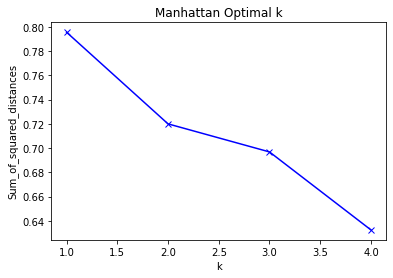

In [12]:
# Elbow analysis
Sum_of_squared_distances = []
range_n_clusters = range(1,5) # Test upto 20 clusters
for k in range_n_clusters:
    km = KMeans(n_clusters=k,init='random',algorithm='full').fit(Manhattan_cluster) # Random initialization and full algorithm: More resource intensive but better for undefined clusters
    Sum_of_squared_distances.append(km.inertia_)

# Build elbow plot
plt.plot(range_n_clusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Manhattan Optimal k')
plt.show()

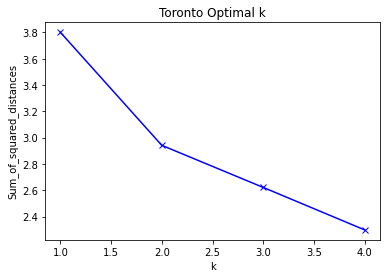

In [13]:
# Elbow analysis
Sum_of_squared_distances = []
range_n_clusters = range(1,5) # Test upto 20 clusters
for k in range_n_clusters:
    km = KMeans(n_clusters=k,init='random',algorithm='full').fit(Toronto_cluster) # Random initialization and full algorithm: More resource intensive but better for undefined clusters
    Sum_of_squared_distances.append(km.inertia_)

# Build elbow plot
plt.plot(range_n_clusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Toronto Optimal k')
plt.show()

## Running K-Means

In [14]:
# set number of clusters
kclusters = 3

In [15]:
# run k-means clustering
KM_Manhattan = KMeans(n_clusters=kclusters,init='random',algorithm='full',verbose=1).fit(Manhattan_cluster)

Initialization complete
Iteration 0, inertia 1.234197840869804.
Iteration 1, inertia 0.711501147920086.
Iteration 2, inertia 0.7100471678776441.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1.1048451476433498.
Iteration 1, inertia 0.7255705076692555.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1187256697930703.
Iteration 1, inertia 0.6853067693877192.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0778916763848525.
Iteration 1, inertia 0.7212057961204338.
Iteration 2, inertia 0.7166103330642181.
Iteration 3, inertia 0.7150566414113927.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 1.0676985965005268.
Iteration 1, inertia 0.660842439880591.
Iteration 2, inertia 0.6591798776907397.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1.1527241336962286.
Iteration 1, i

In [16]:
# run k-means clustering
KM_Toronto = KMeans(n_clusters=kclusters,init='random',algorithm='full',verbose=1).fit(Toronto_cluster)

Initialization complete
Iteration 0, inertia 4.395021089185152.
Iteration 1, inertia 2.979848219088418.
Iteration 2, inertia 2.734861592561435.
Iteration 3, inertia 2.656663734968492.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 4.148113205341371.
Iteration 1, inertia 2.7204054011100265.
Iteration 2, inertia 2.7007130138864106.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.876704306345487.
Iteration 1, inertia 3.2787920049356307.
Iteration 2, inertia 3.2688448094566187.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.8847948594851838.
Iteration 1, inertia 2.688872913402502.
Iteration 2, inertia 2.671846468287956.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.627810761801395.
Iteration 1, inertia 3.5642910582944594.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia

In [17]:
# Merge clustering labels
Manhattan_venues.insert(0,'Cluster Labels',KM_Manhattan.labels_)
Manhattan_merged = Manhattan_geo
# Joins the two table based on neighborhood
Manhattan_merged = Manhattan_merged.join(Manhattan_venues.set_index('Neighborhood'), on='Neighborhood')
Manhattan_merged.head(10) 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,Tennis Stadium,Kids Store,Donut Shop,Diner,Pharmacy
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Bakery,Hotpot Restaurant,Cocktail Bar,Dessert Shop,American Restaurant,Spa,Salon / Barbershop,Shanghai Restaurant,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,1,Café,Bakery,Mobile Phone Shop,Pizza Place,Bank,Coffee Shop,New American Restaurant,Park,Gym,Grocery Store
3,Manhattan,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Restaurant,Lounge,Café,Wine Bar,Pizza Place,Diner,Park,Bakery,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Juice Bar,Latin American Restaurant,Liquor Store,Sushi Restaurant,Park
5,Manhattan,Manhattanville,40.816934,-73.957385,1,Seafood Restaurant,Coffee Shop,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Deli / Bodega,Sushi Restaurant,Grocery Store,Gastropub,Supermarket
6,Manhattan,Central Harlem,40.815976,-73.943211,2,African Restaurant,Gym / Fitness Center,French Restaurant,Seafood Restaurant,Cosmetics Shop,Art Gallery,Bar,American Restaurant,Chinese Restaurant,Boutique
7,Manhattan,East Harlem,40.792249,-73.944182,1,Mexican Restaurant,Deli / Bodega,Bakery,Latin American Restaurant,Thai Restaurant,Sandwich Place,Steakhouse,Spanish Restaurant,Beer Bar,Liquor Store
8,Manhattan,Upper East Side,40.775639,-73.960508,2,Italian Restaurant,Coffee Shop,Bakery,Exhibit,Gym / Fitness Center,Spa,American Restaurant,French Restaurant,Hotel,Juice Bar
9,Manhattan,Yorkville,40.775930,-73.947118,2,Italian Restaurant,Bar,Gym,Coffee Shop,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Wine Shop,Diner,Vietnamese Restaurant


In [18]:
# Merge clustering labels
Toronto_venues.insert(0,'Cluster Labels',KM_Toronto.labels_)
Toronto_merged = Toronto_geo
# Joins the two table based on neighborhood
Toronto_merged = Toronto_merged.join(Toronto_venues.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.head(10) 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.6555,-79.3626,0,Coffee Shop,Breakfast Spot,Yoga Studio,Bakery,Distribution Center,Pub,Electronics Store,Restaurant,Event Space,Food Truck
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783,0,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Café,Hotel,Fast Food Restaurant,Lingerie Store,Diner
2,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756,0,Coffee Shop,Café,Seafood Restaurant,Gastropub,Cocktail Bar,Restaurant,Cosmetics Shop,Italian Restaurant,Creperie,Gym
3,M4E,East Toronto,The Beaches,43.6784,-79.2941,0,Pub,Gastropub,Health Food Store,Trail,Bakery,Wings Joint,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.6456,-79.3754,0,Coffee Shop,Bakery,Café,Hotel,Seafood Restaurant,Restaurant,Cocktail Bar,Beer Bar,Japanese Restaurant,Pub
5,M5G,Downtown Toronto,Central Bay Street,43.6564,-79.3860,0,Coffee Shop,Bubble Tea Shop,Clothing Store,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Sandwich Place,Restaurant,Café,Juice Bar
6,M6G,Downtown Toronto,Christie,43.6683,-79.4205,2,Café,Grocery Store,Park,Coffee Shop,Playground,Candy Store,Athletics & Sports,Baby Store,Fish & Chips Shop,Fast Food Restaurant
7,M5H,Downtown Toronto,"Richmond , Adelaide , King",43.6496,-79.3833,0,Café,Coffee Shop,Restaurant,Gym,Hotel,Salad Place,Steakhouse,Sushi Restaurant,Japanese Restaurant,Thai Restaurant
8,M6H,West Toronto,"Dufferin , Dovercourt Village",43.6655,-79.4378,0,Park,Grocery Store,Bakery,Brazilian Restaurant,Art Gallery,Gym,Bus Line,Pharmacy,Smoke Shop,Middle Eastern Restaurant
9,M4J,East YorkEast Toronto,The Danforth East,43.6872,-79.3368,1,Convenience Store,Park,Intersection,Wings Joint,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant


## Visualizing results of K-Means Clustering

In [19]:
# create map
map_clusters = folium.Map(location=[40.7896239, -73.9598939], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for index, row in Manhattan_merged.iterrows():
    label = folium.Popup(str(row['Neighborhood'])+str(row['Cluster Labels'])+str(row['Cluster Labels']),parse_html=True)
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color=rainbow[int(row['Cluster Labels'])-1],
        fill=True,
        fill_color=rainbow[int(row['Cluster Labels'])-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [20]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for index, row in Toronto_merged.iterrows():
    label = folium.Popup(str(row['Neighborhood'])+str(row['Cluster Labels'])+str(row['Cluster Labels']),parse_html=True)
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color=rainbow[int(row['Cluster Labels'])-1],
        fill=True,
        fill_color=rainbow[int(row['Cluster Labels'])-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Exploring the different clusters

In [21]:
Manhattan_merged.loc[Manhattan_merged['Cluster Labels'] == 0, Manhattan_merged.columns[[1] + list(range(5, Manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Bar,Park,Coffee Shop,Pet Service,Cocktail Bar,Baseball Field,Harbor / Marina,Farmers Market,Heliport,Bistro


In [22]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Breakfast Spot,Yoga Studio,Bakery,Distribution Center,Pub,Electronics Store,Restaurant,Event Space,Food Truck
1,Downtown Toronto,0,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Café,Hotel,Fast Food Restaurant,Lingerie Store,Diner
2,Downtown Toronto,0,Coffee Shop,Café,Seafood Restaurant,Gastropub,Cocktail Bar,Restaurant,Cosmetics Shop,Italian Restaurant,Creperie,Gym
3,East Toronto,0,Pub,Gastropub,Health Food Store,Trail,Bakery,Wings Joint,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
4,Downtown Toronto,0,Coffee Shop,Bakery,Café,Hotel,Seafood Restaurant,Restaurant,Cocktail Bar,Beer Bar,Japanese Restaurant,Pub
5,Downtown Toronto,0,Coffee Shop,Bubble Tea Shop,Clothing Store,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Sandwich Place,Restaurant,Café,Juice Bar
7,Downtown Toronto,0,Café,Coffee Shop,Restaurant,Gym,Hotel,Salad Place,Steakhouse,Sushi Restaurant,Japanese Restaurant,Thai Restaurant
8,West Toronto,0,Park,Grocery Store,Bakery,Brazilian Restaurant,Art Gallery,Gym,Bus Line,Pharmacy,Smoke Shop,Middle Eastern Restaurant
11,West Toronto,0,Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Cocktail Bar,Asian Restaurant,Coffee Shop,Yoga Studio,Music Store,Seafood Restaurant
12,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Café,Restaurant,Yoga Studio,Brewery,Bubble Tea Shop,Cocktail Bar


In [23]:
Manhattan_merged.loc[Manhattan_merged['Cluster Labels'] == 1, Manhattan_merged.columns[[1] + list(range(5, Manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Pizza Place,Bank,Coffee Shop,New American Restaurant,Park,Gym,Grocery Store
3,Inwood,Mexican Restaurant,Restaurant,Lounge,Café,Wine Bar,Pizza Place,Diner,Park,Bakery,Deli / Bodega
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Juice Bar,Latin American Restaurant,Liquor Store,Sushi Restaurant,Park
5,Manhattanville,Seafood Restaurant,Coffee Shop,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Deli / Bodega,Sushi Restaurant,Grocery Store,Gastropub,Supermarket
7,East Harlem,Mexican Restaurant,Deli / Bodega,Bakery,Latin American Restaurant,Thai Restaurant,Sandwich Place,Steakhouse,Spanish Restaurant,Beer Bar,Liquor Store
11,Roosevelt Island,Park,Coffee Shop,Gym / Fitness Center,Gym,Greek Restaurant,Outdoors & Recreation,Liquor Store,Sandwich Place,Scenic Lookout,School
20,Lower East Side,Chinese Restaurant,Ramen Restaurant,Coffee Shop,Latin American Restaurant,Art Gallery,Bakery,Café,Filipino Restaurant,Tennis Court,Bar
25,Manhattan Valley,Mexican Restaurant,Bar,Yoga Studio,Coffee Shop,Indian Restaurant,Thai Restaurant,Pizza Place,Caribbean Restaurant,Hill,Peruvian Restaurant
26,Morningside Heights,Coffee Shop,Bookstore,American Restaurant,Park,Sandwich Place,Café,Burger Joint,Mexican Restaurant,Farmers Market,Seafood Restaurant
28,Battery Park City,Park,Coffee Shop,Gym,Hotel,Memorial Site,Clothing Store,BBQ Joint,Gourmet Shop,Food Court,Pizza Place


In [24]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East YorkEast Toronto,1,Convenience Store,Park,Intersection,Wings Joint,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
17,Central Toronto,1,Park,Photography Studio,Wings Joint,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
20,West Toronto,1,Park,Residential Building (Apartment / Condo),Wings Joint,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [25]:
Manhattan_merged.loc[Manhattan_merged['Cluster Labels'] == 2, Manhattan_merged.columns[[1] + list(range(5, Manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,Tennis Stadium,Kids Store,Donut Shop,Diner,Pharmacy
1,Chinatown,Chinese Restaurant,Bakery,Hotpot Restaurant,Cocktail Bar,Dessert Shop,American Restaurant,Spa,Salon / Barbershop,Shanghai Restaurant,Ice Cream Shop
6,Central Harlem,African Restaurant,Gym / Fitness Center,French Restaurant,Seafood Restaurant,Cosmetics Shop,Art Gallery,Bar,American Restaurant,Chinese Restaurant,Boutique
8,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,Exhibit,Gym / Fitness Center,Spa,American Restaurant,French Restaurant,Hotel,Juice Bar
9,Yorkville,Italian Restaurant,Bar,Gym,Coffee Shop,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Wine Shop,Diner,Vietnamese Restaurant
10,Lenox Hill,Italian Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Cocktail Bar,Café,Gym / Fitness Center,Gym,Burger Joint,Salad Place
12,Upper West Side,Italian Restaurant,Bakery,Mediterranean Restaurant,Bar,Wine Bar,Pizza Place,Café,Coffee Shop,Sports Bar,Pub
13,Lincoln Square,Plaza,Concert Hall,Theater,Café,Performing Arts Venue,Indie Movie Theater,Italian Restaurant,Bakery,French Restaurant,Wine Shop
14,Clinton,Italian Restaurant,Gym / Fitness Center,Theater,Cocktail Bar,Coffee Shop,American Restaurant,Sandwich Place,Gym,Spa,Hotel
15,Midtown,Hotel,Theater,Coffee Shop,Sporting Goods Shop,Clothing Store,Steakhouse,American Restaurant,Bakery,Bookstore,Sandwich Place


In [26]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Downtown Toronto,2,Café,Grocery Store,Park,Coffee Shop,Playground,Candy Store,Athletics & Sports,Baby Store,Fish & Chips Shop,Fast Food Restaurant
10,Downtown Toronto,2,Harbor / Marina,Park,Café,Music Venue,Wings Joint,Dumpling Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
21,Central Toronto,2,Gym Pool,Playground,Park,Garden,Wings Joint,Donut Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
27,Central Toronto,2,Park,Gym,Grocery Store,Thai Restaurant,Wings Joint,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
31,Downtown Toronto,2,Playground,Park,Grocery Store,Candy Store,Wings Joint,Dumpling Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant


## Performing agglomarative clustering

In [27]:
# Define dendogram function
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [28]:
Model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

### Generating dendrograms

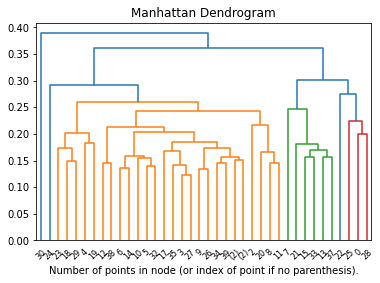

In [29]:
Manhattan = Model.fit(Manhattan_cluster)
plt.title('Manhattan Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(Manhattan, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

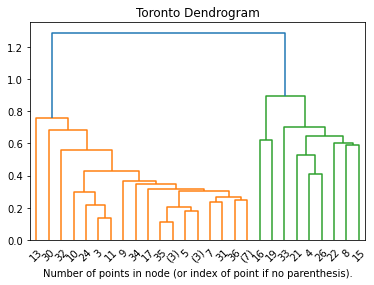

In [30]:
Toronto = Model.fit(Toronto_cluster)
plt.title('Toronto Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(Toronto, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Interesting unique neighbourhoods

In [31]:
print(Manhattan_df['Neighborhood'][32])
Manhattan_merged[Manhattan_merged['Neighborhood'] == Manhattan_df['Neighborhood'][32]]

Tribeca


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Manhattan,Tribeca,40.721522,-74.010683,2,Italian Restaurant,American Restaurant,Park,Spa,Wine Bar,Café,French Restaurant,Scenic Lookout,Steakhouse,Poke Place


In [32]:
print(Manhattan_df['Neighborhood'][22])
Manhattan_merged[Manhattan_merged['Neighborhood'] == Manhattan_df['Neighborhood'][22]]

Marble Hill


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.91066,2,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,Tennis Stadium,Kids Store,Donut Shop,Diner,Pharmacy


In [34]:
print(Manhattan_df['Neighborhood'][24])
Manhattan_merged[Manhattan_merged['Neighborhood'] == Manhattan_df['Neighborhood'][24]]

Midtown South


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Manhattan,Midtown South,40.74851,-73.988713,2,Korean Restaurant,Hotel,Hotel Bar,Japanese Restaurant,Dessert Shop,American Restaurant,Salad Place,Café,Coffee Shop,Cosmetics Shop
